# AnomalyCLR for jet physics

In [1]:
import sys
import os
import numpy as np

from matplotlib import pyplot as plt
import colorsys
import matplotlib
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties


import torch
import random

from jet_augs import *

In [2]:
labelfont = FontProperties()
labelfont.set_family('serif')
labelfont.set_name('Times New Roman')
labelfont.set_size(14)

axislabelfont = FontProperties()
axislabelfont.set_family('serif')
axislabelfont.set_name('Times New Roman')
axislabelfont.set_size(22)

tickfont = FontProperties()
tickfont.set_family('serif')
tickfont.set_name('Times New Roman')
tickfont.set_size(16)

axisfontsize = 16
labelfontsize = 16

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams['text.usetex'] = True

Below we load the data from the top tagging challenge.

In [3]:
qcd = np.load( "../rep-learning/qcd_100k_constit.npy" )
top = np.load( "../rep-learning/top_100k_constit.npy" )

In [4]:
qcd.shape

(100000, 3, 200)

In [5]:
top.shape

(100000, 3, 200)

# Augmentations

Here we look at two simple augmentations from the JetCLR work that the jets should be (approximately) invariant to.

## rotations

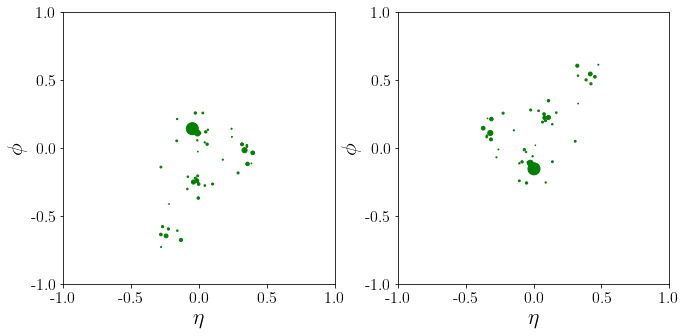

In [6]:
fig, axs = plt.subplots( 1, 2, figsize=(11,5) )

j=4
jet1 = top[j]
jet2 = rotate_jets(top)[j]

axs[0].scatter( jet1[1,:], jet1[2,:], s=jet1[0,:], c="green" )
axs[1].scatter( jet2[1,:], jet2[2,:], s=jet2[0,:], c="green" )

axs[0].axis('square')
axs[1].axis('square')

axs[0].set_xlim((-1.0,1.0))
axs[0].set_ylim((-1.0,1.0))
axs[1].set_xlim((-1.0,1.0))
axs[1].set_ylim((-1.0,1.0))

axs[0].set_xlabel( "$\eta$", fontproperties=axislabelfont)
axs[0].set_ylabel( "$\phi$", fontproperties=axislabelfont)
axs[1].set_xlabel( "$\eta$", fontproperties=axislabelfont)
axs[1].set_ylabel( "$\phi$", fontproperties=axislabelfont)

axs[0].set_xticks( [ -1.0, -0.5, 0.0, 0.5, 1.0 ] )
axs[0].set_xticklabels( [ -1.0, -0.5, 0.0, 0.5, 1.0 ], fontproperties=tickfont )
axs[1].set_xticks( [ -1.0, -0.5, 0.0, 0.5, 1.0 ] )
axs[1].set_xticklabels( [ -1.0, -0.5, 0.0, 0.5, 1.0 ], fontproperties=tickfont )

axs[0].set_yticks( [ -1.0, -0.5, 0.0, 0.5, 1.0 ] )
axs[0].set_yticklabels( [ -1.0, -0.5, 0.0, 0.5, 1.0 ], fontproperties=tickfont )
axs[1].set_yticks( [ -1.0, -0.5, 0.0, 0.5, 1.0 ] )
axs[1].set_yticklabels( [ -1.0, -0.5, 0.0, 0.5, 1.0 ], fontproperties=tickfont );

## $\eta\!-\!\phi$ smearing

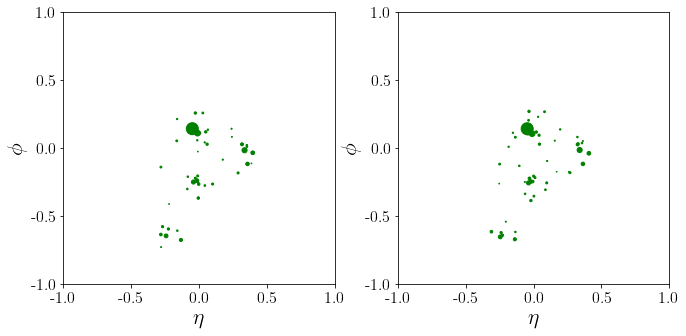

In [8]:
fig, axs = plt.subplots( 1, 2, figsize=(11,5) )

j=4
jet1 = top[j]
jet2 = distort_jets(top)[j]

axs[0].scatter( jet1[1,:], jet1[2,:], s=jet1[0,:], c="green" )
axs[1].scatter( jet2[1,:], jet2[2,:], s=jet2[0,:], c="green" )

axs[0].axis('square')
axs[1].axis('square')

axs[0].set_xlim((-1.0,1.0))
axs[0].set_ylim((-1.0,1.0))
axs[1].set_xlim((-1.0,1.0))
axs[1].set_ylim((-1.0,1.0))

axs[0].set_xlabel( "$\eta$", fontproperties=axislabelfont)
axs[0].set_ylabel( "$\phi$", fontproperties=axislabelfont)
axs[1].set_xlabel( "$\eta$", fontproperties=axislabelfont)
axs[1].set_ylabel( "$\phi$", fontproperties=axislabelfont)

axs[0].set_xticks( [ -1.0, -0.5, 0.0, 0.5, 1.0 ] )
axs[0].set_xticklabels( [ -1.0, -0.5, 0.0, 0.5, 1.0 ], fontproperties=tickfont )
axs[1].set_xticks( [ -1.0, -0.5, 0.0, 0.5, 1.0 ] )
axs[1].set_xticklabels( [ -1.0, -0.5, 0.0, 0.5, 1.0 ], fontproperties=tickfont )

axs[0].set_yticks( [ -1.0, -0.5, 0.0, 0.5, 1.0 ] )
axs[0].set_yticklabels( [ -1.0, -0.5, 0.0, 0.5, 1.0 ], fontproperties=tickfont )
axs[1].set_yticks( [ -1.0, -0.5, 0.0, 0.5, 1.0 ] )
axs[1].set_yticklabels( [ -1.0, -0.5, 0.0, 0.5, 1.0 ], fontproperties=tickfont );

# Anomaly augmentations

Here we define the anomaly augmentations for producing highly expressive jet representations sensitive to potential anomalous new physics signals.

We will need the two functions below to standardize the jets after the augmentations have been applied.

In [10]:
def rescale_pt(dataset):
    for i in range(0, dataset.shape[0]):
        dataset[i,0,:] = dataset[i,0,:]/600
    return dataset

In [11]:
def recentre_jet(batch):
    batchc = batch.copy()
    nj = batch.shape[0]
    for i in range( nj ):
        pts = batch[i,0,:]
        etas = batch[i,1,:]
        phis = batch[i,2,:]
        nc = len( pts )
        eta_shift = np.sum( [ pts[j]*etas[j] for j in range( nc ) ] ) / np.sum( pts )
        phi_shift = np.sum( [ pts[j]*phis[j] for j in range( nc ) ] ) / np.sum( pts )
        batchc[i,1,:] = batch[i,1,:] - eta_shift
        batchc[i,2,:] = batch[i,2,:] - phi_shift
    return batchc


## anomaly augmentations - drop constituents

This augmentaion can be used to mimic what might be observed in semi-visible jets arising from dark matter models.  Constituents are dropped on a random basis, which is currently done independently of the constituents $p_T$.  It would be easy to make this random selection $p_T$ dependent however.

In [12]:
def drop_constits_jet( batch, prob=0.3 ):
    '''
    Input: batch of jets, shape (batchsize, 3, n_constit)
    Dim 1 ordering: (pT, eta, phi)
    Output: batch of jets where each jet has some fraction of missing constituents
    Note: rescale pts so that the augmented jet pt matches the original
    '''
    batchc = batch.copy()
    nj = batchc.shape[0]
    nc = batchc.shape[2]
    nzs = np.array( [ np.where( batchc[:,0,:]>0.0 )[0].shape[0] for i in range(len(batch)) ] )
    mask = np.array( np.random.rand( nj, nc ) > prob, dtype='int' )
    for i in range( nj ):
        for j in range( nc ):
            if mask[i][j]==0:
                batchc[i,:,j] = np.array([0.0,0.0,0.0])
    pts = np.sum( batch[:,0,:], axis=1 )
    pts_aug = np.sum( batchc[:,0,:], axis=1 )
    pt_rescale = [ pts[i]/pts_aug[i] for i in range(nj) ]
    for i in range(nj):
        batchc[i,0,:] = batchc[i,0,:]*pt_rescale[i]
    return recentre_jet( batchc )

Text(-0.95, 0.95, 'constit-drop, \\texttt{prob}$=\\!0.6$')

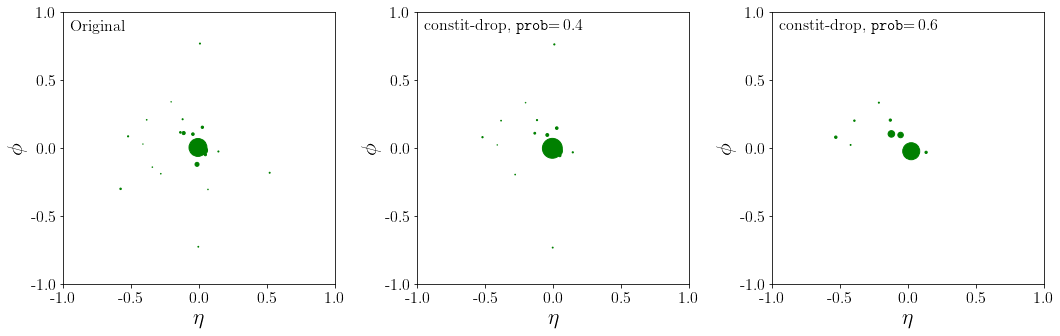

In [13]:
fig, axs = plt.subplots( 1, 3, figsize=(18,5) )

jets = qcd[0:100]
j = 99
jet1 = jets[j]
jet2 = drop_constits_jet( jets, prob=0.4 )[j]
jet3 = drop_constits_jet( jets, prob=0.6 )[j]

axs[0].scatter( jet1[1,:], jet1[2,:], s=jet1[0,:], c="green" )
axs[1].scatter( jet2[1,:], jet2[2,:], s=jet2[0,:], c="green" )
axs[2].scatter( jet3[1,:], jet3[2,:], s=jet3[0,:], c="green" )

axs[0].axis('square')
axs[1].axis('square')
axs[2].axis('square')

axs[0].set_xlim((-1.0,1.0))
axs[0].set_ylim((-1.0,1.0))
axs[1].set_xlim((-1.0,1.0))
axs[1].set_ylim((-1.0,1.0))
axs[2].set_xlim((-1.0,1.0))
axs[2].set_ylim((-1.0,1.0))

axs[0].set_xlabel( "$\eta$", fontproperties=axislabelfont)
axs[0].set_ylabel( "$\phi$", fontproperties=axislabelfont)
axs[1].set_xlabel( "$\eta$", fontproperties=axislabelfont)
axs[1].set_ylabel( "$\phi$", fontproperties=axislabelfont)
axs[2].set_xlabel( "$\eta$", fontproperties=axislabelfont)
axs[2].set_ylabel( "$\phi$", fontproperties=axislabelfont)

axs[0].set_xticks( [ -1.0, -0.5, 0.0, 0.5, 1.0 ] )
axs[0].set_xticklabels( [ -1.0, -0.5, 0.0, 0.5, 1.0 ], fontproperties=tickfont )
axs[1].set_xticks( [ -1.0, -0.5, 0.0, 0.5, 1.0 ] )
axs[1].set_xticklabels( [ -1.0, -0.5, 0.0, 0.5, 1.0 ], fontproperties=tickfont )
axs[2].set_xticks( [ -1.0, -0.5, 0.0, 0.5, 1.0 ] )
axs[2].set_xticklabels( [ -1.0, -0.5, 0.0, 0.5, 1.0 ], fontproperties=tickfont )

axs[0].set_yticks( [ -1.0, -0.5, 0.0, 0.5, 1.0 ] )
axs[0].set_yticklabels( [ -1.0, -0.5, 0.0, 0.5, 1.0 ], fontproperties=tickfont )
axs[1].set_yticks( [ -1.0, -0.5, 0.0, 0.5, 1.0 ] )
axs[1].set_yticklabels( [ -1.0, -0.5, 0.0, 0.5, 1.0 ], fontproperties=tickfont )
axs[2].set_yticks( [ -1.0, -0.5, 0.0, 0.5, 1.0 ] )
axs[2].set_yticklabels( [ -1.0, -0.5, 0.0, 0.5, 1.0 ], fontproperties=tickfont )

axs[0].text( -0.95, 0.95,  "Original", va='top', ha='left', fontproperties=tickfont )
axs[1].text( -0.95, 0.95,  "constit-drop, \\texttt{prob}$=\!0.4$", va='top', ha='left', fontproperties=tickfont )
axs[2].text( -0.95, 0.95,  "constit-drop, \\texttt{prob}$=\!0.6$", va='top', ha='left', fontproperties=tickfont )

#fig.savefig("drop-constit-aug.pdf");


## anomaly augmentations - subjet shifts

This augmentation can be used to mimic jets containing a heavy decaying particle, which produces a multi-prong jet shape.  The functions takes the number of subjets you want the augmentation to produce, along with a weight vector which determines how many constituents will belong to each cluster.  Currently, this selection is done without consideration of the constituents $p_T$, however it would be easy to make this $p_T$ dependent.  This could also be updated to select constituents based on locality rather than $p_T$.

In [62]:
def subjet_shift_jet( batch, nsubs=1, probs=[0.5], R=0.8 ):
    '''
    Input: batch of jets, shape (batchsize, 3, n_constit)
    Dim 1 ordering: (pT, eta, phi)
    Output: batch of jets where a subset of constituents have been shifted
    Note: probs should be a vector of length nsubs, drop anything that falls outside the jet radius 
        and re-scale pts so that augmented jets have the same pTs as the originals,
        so choose sensible parameters in the function.
    '''
    batchc = batch.copy()
    nj = batchc.shape[0]
    nc = batchc.shape[2]
    eta_shifts = np.array( [ ( np.random.rand( nj ) - 0.5 )/(1*R) for i in range(nsubs) ] )
    phi_shifts = np.array( [ ( np.random.rand( nj ) - 0.5 )/(1*R) for i in range(nsubs) ] )
    masks = np.array( [ np.array( np.random.rand( nj, nc ) > probs[i], dtype='int' ) for i in range(nsubs) ] )
    for i in range( nj ):
        for j in range( nc ):
            for k in range( nsubs ):
                if np.all( np.array( [ masks[l][i][j] for l in range(k+1) ] ) == 0 ):
                    batchc[i,1,j] = batchc[i,1,j] + eta_shifts[k][i]
                    batchc[i,2,j] = batchc[i,2,j] + phi_shifts[k][i]
    batchc = recentre_jet( batchc )
    for i in range( nj ):
        for j in range( nc ):
            if np.sqrt( batchc[i,1,j]**2 + batchc[i,2,j]**2 ) > R:
                batchc[i,:,j] = np.array( [0.0,0.0,0.0] )
    pts = np.sum( batch[:,0,:], axis=1 )
    pts_aug = np.sum( batchc[:,0,:], axis=1 )
    pt_rescale = [ pts[i]/pts_aug[i] for i in range(nj) ]
    for i in range(nj):
        batchc[i,0,:] = batchc[i,0,:]*pt_rescale[i]
    batchc = recentre_jet( batchc )
    return batchc

Text(-0.95, 0.95, 'subjet-shift, \\texttt{nsub}$=\\!2$, \\texttt{probs}$=\\![0.5,0.5]$')

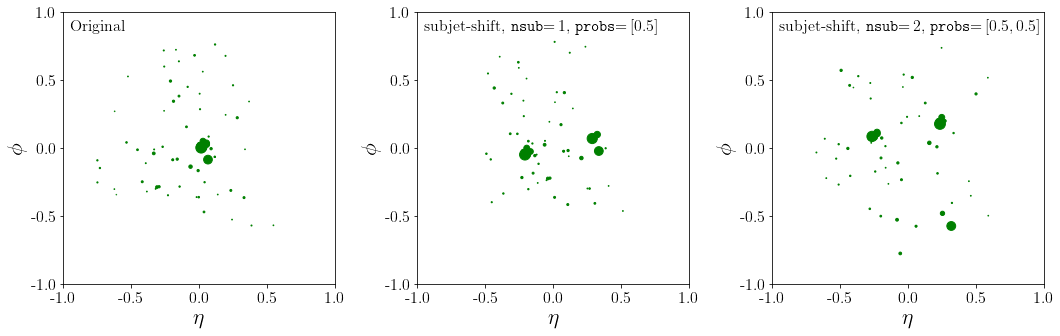

In [67]:
fig, axs = plt.subplots( 1, 3, figsize=(18,5) )

jets = qcd[0:100]
j = 77
jet1 = jets[j]
jet2 = subjet_shift_jet( jets, nsubs=1, probs=[0.5] )[j]
jet3 = subjet_shift_jet( jets, nsubs=2, probs=[0.5,0.5] )[j]

axs[0].scatter( jet1[1,:], jet1[2,:], s=jet1[0,:], c="green" )
axs[1].scatter( jet2[1,:], jet2[2,:], s=jet2[0,:], c="green" )
axs[2].scatter( jet3[1,:], jet3[2,:], s=jet3[0,:], c="green" )

axs[0].axis('square')
axs[1].axis('square')
axs[2].axis('square')

axs[0].set_xlim((-1.0,1.0))
axs[0].set_ylim((-1.0,1.0))
axs[1].set_xlim((-1.0,1.0))
axs[1].set_ylim((-1.0,1.0))
axs[2].set_xlim((-1.0,1.0))
axs[2].set_ylim((-1.0,1.0))

axs[0].set_xlabel( "$\eta$", fontproperties=axislabelfont)
axs[0].set_ylabel( "$\phi$", fontproperties=axislabelfont)
axs[1].set_xlabel( "$\eta$", fontproperties=axislabelfont)
axs[1].set_ylabel( "$\phi$", fontproperties=axislabelfont)
axs[2].set_xlabel( "$\eta$", fontproperties=axislabelfont)
axs[2].set_ylabel( "$\phi$", fontproperties=axislabelfont)

axs[0].set_xticks( [ -1.0, -0.5, 0.0, 0.5, 1.0 ] )
axs[0].set_xticklabels( [ -1.0, -0.5, 0.0, 0.5, 1.0 ], fontproperties=tickfont )
axs[1].set_xticks( [ -1.0, -0.5, 0.0, 0.5, 1.0 ] )
axs[1].set_xticklabels( [ -1.0, -0.5, 0.0, 0.5, 1.0 ], fontproperties=tickfont )
axs[2].set_xticks( [ -1.0, -0.5, 0.0, 0.5, 1.0 ] )
axs[2].set_xticklabels( [ -1.0, -0.5, 0.0, 0.5, 1.0 ], fontproperties=tickfont )

axs[0].set_yticks( [ -1.0, -0.5, 0.0, 0.5, 1.0 ] )
axs[0].set_yticklabels( [ -1.0, -0.5, 0.0, 0.5, 1.0 ], fontproperties=tickfont )
axs[1].set_yticks( [ -1.0, -0.5, 0.0, 0.5, 1.0 ] )
axs[1].set_yticklabels( [ -1.0, -0.5, 0.0, 0.5, 1.0 ], fontproperties=tickfont )
axs[2].set_yticks( [ -1.0, -0.5, 0.0, 0.5, 1.0 ] )
axs[2].set_yticklabels( [ -1.0, -0.5, 0.0, 0.5, 1.0 ], fontproperties=tickfont )

axs[0].text( -0.95, 0.95,  "Original", va='top', ha='left', fontproperties=tickfont )
axs[1].text( -0.95, 0.95,  "subjet-shift, \\texttt{nsub}$=\!1$, \\texttt{probs}$=\![0.5]$", va='top', ha='left', fontproperties=tickfont )
axs[2].text( -0.95, 0.95,  "subjet-shift, \\texttt{nsub}$=\!2$, \\texttt{probs}$=\![0.5,0.5]$", va='top', ha='left', fontproperties=tickfont )

#fig.savefig("subjet-shift-aug.pdf");

## anomaly augmentations - pT reweight

Some jets from new physics models may produce jets whose momenta is distributed differently over the jets constituents, this augmentation is designed to mimic these effects.

In [68]:
def pt_reweight_jet( batch, beta=1.5 ):
    '''
    Input: batch of jets, shape (batchsize, 3, n_constit)
    Dim 1 ordering: (pT, eta, phi)
    Output: batch of jets where the pt of the constituents in each jet has has been re-weighted by some power
    Note: rescale pts so that the augmented jet pt matches the original
    '''
    batchc = batch.copy()
    nj = batchc.shape[0]
    nc = batchc.shape[2]
    for i in range( nj ):
        for j in range( nc ):
            batchc[i,0,j] = batch[i,0,j]**beta
    pts = np.sum( batch[:,0,:], axis=1 )
    pts_aug = np.sum( batchc[:,0,:], axis=1 )
    pt_rescale = [ pts[i]/pts_aug[i] for i in range(nj) ]
    for i in range(nj):
        batchc[i,0,:] = batchc[i,0,:]*pt_rescale[i]
    return recentre_jet( batchc )

Text(-0.95, 0.95, '$p_T$-reweight, \\texttt{beta}$=\\!0.4$')

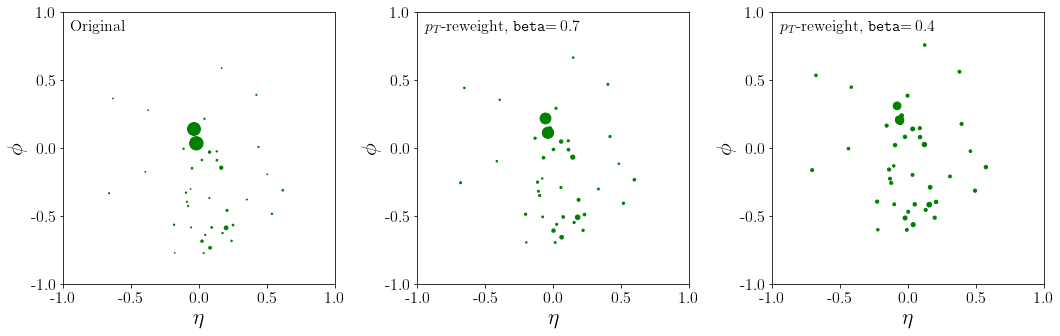

In [69]:
fig, axs = plt.subplots( 1, 3, figsize=(18,5) )

jets = qcd[0:100]
j = 88
jet1 = jets[j]
jet2 = pt_reweight_jet( jets, beta=0.7 )[j]
jet3 = pt_reweight_jet( jets, beta=0.4 )[j]

axs[0].scatter( jet1[1,:], jet1[2,:], s=jet1[0,:], c="green" )
axs[1].scatter( jet2[1,:], jet2[2,:], s=jet2[0,:], c="green" )
axs[2].scatter( jet3[1,:], jet3[2,:], s=jet3[0,:], c="green" )

axs[0].axis('square')
axs[1].axis('square')
axs[2].axis('square')

axs[0].set_xlim((-1.0,1.0))
axs[0].set_ylim((-1.0,1.0))
axs[1].set_xlim((-1.0,1.0))
axs[1].set_ylim((-1.0,1.0))
axs[2].set_xlim((-1.0,1.0))
axs[2].set_ylim((-1.0,1.0))

axs[0].set_xlabel( "$\eta$", fontproperties=axislabelfont)
axs[0].set_ylabel( "$\phi$", fontproperties=axislabelfont)
axs[1].set_xlabel( "$\eta$", fontproperties=axislabelfont)
axs[1].set_ylabel( "$\phi$", fontproperties=axislabelfont)
axs[2].set_xlabel( "$\eta$", fontproperties=axislabelfont)
axs[2].set_ylabel( "$\phi$", fontproperties=axislabelfont)

axs[0].set_xticks( [ -1.0, -0.5, 0.0, 0.5, 1.0 ] )
axs[0].set_xticklabels( [ -1.0, -0.5, 0.0, 0.5, 1.0 ], fontproperties=tickfont )
axs[1].set_xticks( [ -1.0, -0.5, 0.0, 0.5, 1.0 ] )
axs[1].set_xticklabels( [ -1.0, -0.5, 0.0, 0.5, 1.0 ], fontproperties=tickfont )
axs[2].set_xticks( [ -1.0, -0.5, 0.0, 0.5, 1.0 ] )
axs[2].set_xticklabels( [ -1.0, -0.5, 0.0, 0.5, 1.0 ], fontproperties=tickfont )

axs[0].set_yticks( [ -1.0, -0.5, 0.0, 0.5, 1.0 ] )
axs[0].set_yticklabels( [ -1.0, -0.5, 0.0, 0.5, 1.0 ], fontproperties=tickfont )
axs[1].set_yticks( [ -1.0, -0.5, 0.0, 0.5, 1.0 ] )
axs[1].set_yticklabels( [ -1.0, -0.5, 0.0, 0.5, 1.0 ], fontproperties=tickfont )
axs[2].set_yticks( [ -1.0, -0.5, 0.0, 0.5, 1.0 ] )
axs[2].set_yticklabels( [ -1.0, -0.5, 0.0, 0.5, 1.0 ], fontproperties=tickfont )

axs[0].text( -0.95, 0.95,  "Original", va='top', ha='left', fontproperties=tickfont )
axs[1].text( -0.95, 0.95,  "$p_T$-reweight, \\texttt{beta}$=\!0.7$", va='top', ha='left', fontproperties=tickfont )
axs[2].text( -0.95, 0.95,  "$p_T$-reweight, \\texttt{beta}$=\!0.4$", va='top', ha='left', fontproperties=tickfont )


#fig.savefig("pt-reweight-aug.pdf");